# Cloud Bounding Boxes

This notebook is an attempt to convert Chris's excellent notebook [here](https://www.kaggle.com/code/cdeotte/cloud-bounding-boxes-lb-0-61) from Tensorflow/Keras to PyTorch. Some code cells that did not use Tensorflow/Keras were re-used with no edits made.

**Everything is based on Chris's notebook.** <br>
All credit belongs to the original author!

## Objective

- In this kernel we will attempt to create bounding boxes instead of segmentation.

# Imports

In [38]:
import os
import gc
import cv2
import timm
import time
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from PIL import Image
import albumentations
from tqdm import tqdm
import matplotlib.pyplot as plt, time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score

from utils import rle2mask, rle2bb, bb2dice, bb2rle, dice_coef6, mask2contour

# Load Data

In [2]:
train = pd.read_csv("./data/understanding_clouds/train.csv")
train["Image"] = train["Image_Label"].map(lambda x: x.split(".")[0])
train["Label"] = train["Image_Label"].map(lambda x: x.split("_")[1])
train.head()

Image_Label                                      EncodedPixels  \
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...   
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...   
2  0011165.jpg_Gravel                                                NaN   
3   0011165.jpg_Sugar                                                NaN   
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...   

     Image   Label  
0  0011165    Fish  
1  0011165  Flower  
2  0011165  Gravel  
3  0011165   Sugar  
4  002be4f    Fish

In [3]:
train2 = pd.DataFrame({"Image": train["Image"][::4]})
train2.head()

Image
0   0011165
4   002be4f
8   0031ae9
12  0035239
16  003994e

In [4]:
train2["e1"] = train["EncodedPixels"][::4].values
train2["e2"] = train["EncodedPixels"][1::4].values
train2["e3"] = train["EncodedPixels"][2::4].values
train2["e4"] = train["EncodedPixels"][3::4].values
train2.head()

Image                                                 e1  \
0   0011165  264918 937 266318 937 267718 937 269118 937 27...   
4   002be4f  233813 878 235213 878 236613 878 238010 881 23...   
8   0031ae9  3510 690 4910 690 6310 690 7710 690 9110 690 1...   
12  0035239                                                NaN   
16  003994e  2367966 18 2367985 2 2367993 8 2368002 62 2369...   

                                                   e2  \
0   1355565 1002 1356965 1002 1358365 1002 1359765...   
4   1339279 519 1340679 519 1342079 519 1343479 51...   
8   2047 703 3447 703 4847 703 6247 703 7647 703 9...   
12  100812 462 102212 462 103612 462 105012 462 10...   
16                                                NaN   

                                                   e3  \
0                                                 NaN   
4                                                 NaN   
8                                                 NaN   
12  65400 380 66800 380 68200 380 69600 380 71000 ...   
16  353317 416 354717 416 356117 416 357517 416 35...   

                                                   e4  
0                                                 NaN  
4   67495 350 68895 350 70295 350 71695 350 73095 ...  
8   658170 388 659570 388 660970 388 662370 388 66...  
12                                                NaN  
16  28011 489 29411 489 30811 489 32211 489 33611 ...

In [5]:
train2.set_index("Image", inplace=True, drop=True)
train2.fillna("", inplace=True)
train2.head()

e1  \
Image                                                        
0011165  264918 937 266318 937 267718 937 269118 937 27...   
002be4f  233813 878 235213 878 236613 878 238010 881 23...   
0031ae9  3510 690 4910 690 6310 690 7710 690 9110 690 1...   
0035239                                                      
003994e  2367966 18 2367985 2 2367993 8 2368002 62 2369...   

                                                        e2  \
Image                                                        
0011165  1355565 1002 1356965 1002 1358365 1002 1359765...   
002be4f  1339279 519 1340679 519 1342079 519 1343479 51...   
0031ae9  2047 703 3447 703 4847 703 6247 703 7647 703 9...   
0035239  100812 462 102212 462 103612 462 105012 462 10...   
003994e                                                      

                                                        e3  \
Image                                                        
0011165                                                      
002be4f                                                      
0031ae9                                                      
0035239  65400 380 66800 380 68200 380 69600 380 71000 ...   
003994e  353317 416 354717 416 356117 416 357517 416 35...   

                                                        e4  
Image                                                       
0011165                                                     
002be4f  67495 350 68895 350 70295 350 71695 350 73095 ...  
0031ae9  658170 388 659570 388 660970 388 662370 388 66...  
0035239                                                     
003994e  28011 489 29411 489 30811 489 32211 489 33611 ...

In [6]:
train2[["d1", "d2", "d3", "d4"]] = (train2[["e1", "e2", "e3", "e4"]] != "").astype(
    "int8"
)
train2[["d1", "d2", "d3", "d4"]].head()
train2.head()

e1  \
Image                                                        
0011165  264918 937 266318 937 267718 937 269118 937 27...   
002be4f  233813 878 235213 878 236613 878 238010 881 23...   
0031ae9  3510 690 4910 690 6310 690 7710 690 9110 690 1...   
0035239                                                      
003994e  2367966 18 2367985 2 2367993 8 2368002 62 2369...   

                                                        e2  \
Image                                                        
0011165  1355565 1002 1356965 1002 1358365 1002 1359765...   
002be4f  1339279 519 1340679 519 1342079 519 1343479 51...   
0031ae9  2047 703 3447 703 4847 703 6247 703 7647 703 9...   
0035239  100812 462 102212 462 103612 462 105012 462 10...   
003994e                                                      

                                                        e3  \
Image                                                        
0011165                                                      
002be4f                                                      
0031ae9                                                      
0035239  65400 380 66800 380 68200 380 69600 380 71000 ...   
003994e  353317 416 354717 416 356117 416 357517 416 35...   

                                                        e4  d1  d2  d3  d4  
Image                                                                       
0011165                                                      1   1   0   0  
002be4f  67495 350 68895 350 70295 350 71695 350 73095 ...   1   1   0   1  
0031ae9  658170 388 659570 388 660970 388 662370 388 66...   1   1   0   1  
0035239                                                      0   1   1   0  
003994e  28011 489 29411 489 30811 489 32211 489 33611 ...   1   0   1   1

In [7]:
target_cols = train2.iloc[:, 4:8].columns.tolist()
target_cols

['d1', 'd2', 'd3', 'd4']

In [8]:
sub = pd.read_csv("./data/understanding_clouds/sample_submission.csv")
sub["Image"] = sub["Image_Label"].map(lambda x: x.split(".")[0])
sub["Label"] = sub["Image_Label"].map(lambda x: x.split("_")[1])
sub.head()

Image_Label EncodedPixels    Image   Label
0    002f507.jpg_Fish           1 1  002f507    Fish
1  002f507.jpg_Flower           1 1  002f507  Flower
2  002f507.jpg_Gravel           1 1  002f507  Gravel
3   002f507.jpg_Sugar           1 1  002f507   Sugar
4    0035ae9.jpg_Fish           1 1  0035ae9    Fish

In [9]:
sub2 = pd.DataFrame({"Image": sub["Image"][::4]}).reset_index(drop=True)
print(sub2.shape)
sub2.head()

(3698, 1)


Image
0  002f507
1  0035ae9
2  0038327
3  004f759
4  005ba08

In [10]:
sub2.set_index("Image", inplace=True, drop=True)
sub2.fillna("", inplace=True)
sub2.head()

Empty DataFrame
Columns: []
Index: [002f507, 0035ae9, 0038327, 004f759, 005ba08]

# Dataset

In [11]:
class CloudDataset(Dataset):
    def __init__(self, df, transform=None, mode="train", dft=1):
        self.df = df
        self.transform = transform
        self.mode = mode
        if self.mode == "train" or self.mode == "train_bb":
            self.labels = self.df[target_cols].values
        self.dft = dft

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        if self.mode == "train":
            image_id = self.df.index[index]
            path = f"./data/understanding_clouds/train_images/{image_id}.jpg"

            if os.path.exists(path):
                img = cv2.imread(path, cv2.IMREAD_COLOR)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                if self.transform is not None:
                    res = self.transform(image=img)
                    img = res["image"]

                img = img.astype(np.float32)
                img = img.transpose(2, 0, 1)
                label = torch.tensor(self.labels[index]).float()

                return torch.tensor(img).float(), label

        elif self.mode == "train_bb":
            image_id = self.df.index[index]
            path = f"./data/understanding_clouds/train_images/{image_id}.jpg"

            if os.path.exists(path):
                img = cv2.imread(path, cv2.IMREAD_COLOR)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                if self.transform is not None:
                    res = self.transform(image=img)
                    img = res["image"]

                img = img.astype(np.float32)
                img = img.transpose(2, 0, 1)
                label = torch.tensor(self.labels[index]).float()

                # BOUNDING BOXES
                if self.mode == "train_bb":
                    bb = self.df["b" + str(self.dft)]
                    bb = torch.tensor(bb[index]).float() // 4

                return torch.tensor(img).float(), bb

        elif self.mode == "predict":
            image_id = self.df.index[index]
            path = f"./data/understanding_clouds/test_images/{image_id}.jpg"

            if os.path.exists(path):
                img = cv2.imread(path, cv2.IMREAD_COLOR)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                if self.transform is not None:
                    res = self.transform(image=img)
                    img = res["image"]

                img = img.astype(np.float32)
                img = img.transpose(2, 0, 1)

                return torch.tensor(img).float()

In [12]:
transforms_train = albumentations.Compose(
    [
        albumentations.Resize(350, 512, interpolation=cv2.INTER_AREA),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.VerticalFlip(p=0.5),
        albumentations.Normalize(),
    ]
)

transforms_valid = albumentations.Compose(
    [
        albumentations.Resize(350, 512, interpolation=cv2.INTER_AREA),
        albumentations.Normalize(),
    ]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

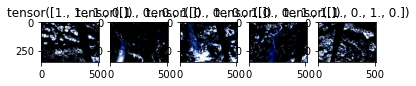

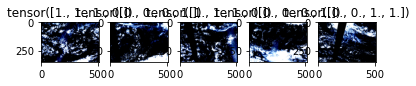

In [13]:
train_image = CloudDataset(train2[:1000], transform=transforms_train)

import matplotlib.pyplot as plt
from pylab import rcParams

rcParams["figure.figsize"] = 20, 10
for i in range(2):
    f, axarr = plt.subplots(1, 5)
    for p in range(5):
        idx = np.random.randint(0, len(train_image))
        img, lbl = train_image[idx]
        axarr[p].imshow(img.transpose(0, 1).transpose(1, 2))
        axarr[p].set_title(lbl)

# Build Classifier

We will use pretrained ResNet50 model with 4 sigmoid outputs and binary_crossentropy loss to classify our cloud images.

In [14]:
class resnet50(nn.Module):
    def __init__(self, model):
        super(resnet50, self).__init__()

        self.features = list(model.children())[:-2]
        self.features = nn.Sequential(*self.features)
        self.pooling = model.global_pool
        self.fc = nn.Linear(in_features=2048, out_features=4)

    def forward(self, x):
        out = self.features(x)
        out = self.pooling(out)
        out = self.fc(out)
        return out

In [15]:
num_gpu = torch.cuda.device_count()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

m = timm.create_model('resnet50', pretrained=True)
model = resnet50(m).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 3)
criterion = nn.BCEWithLogitsLoss()

In [16]:
def train_func(train_loader):
    model.train()
    bar = tqdm(train_loader)
    scaler = torch.cuda.amp.GradScaler()
    losses = []
    for batch_idx, (images, targets) in enumerate(bar):
        images, targets = images.to(device), targets.to(device)

        with torch.cuda.amp.autocast():
            logits = model(images)
            loss = criterion(logits, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        losses.append(loss.item())
        smooth_loss = np.mean(losses[-30:])

        bar.set_description(f"loss: {loss.item():.5f}, smth: {smooth_loss:.5f}")

    loss_train = np.mean(losses)
    return loss_train


def valid_func(valid_loader):
    model.eval()
    bar = tqdm(valid_loader)

    PROB = []
    TARGETS = []
    losses = []
    PREDS = []

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(bar):

            images, targets = images.to(device), targets.to(device)
            logits = model(images)

            PREDS += [logits.sigmoid()]
            TARGETS += [targets.detach().cpu()]

            loss = criterion(logits, targets)
            losses.append(loss.item())
            smooth_loss = np.mean(losses[-30:])
            bar.set_description(f"loss: {loss.item():.5f}, smth: {smooth_loss:.5f}")

    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    loss_valid = np.mean(losses)

    preds = np.array(PREDS) >= 0.5
    targs = np.array(TARGETS)
    accuracy = (targs == preds).mean() * 100

    return loss_valid, accuracy


def oof_func(valid_loader):
    model.eval()
    bar = tqdm(valid_loader)

    PROB = []
    TARGETS = []
    losses = []
    PREDS = []

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(bar):

            images, targets = images.to(device), targets.to(device)
            logits = model(images)

            PREDS += [logits.sigmoid()]
            TARGETS += [targets.detach().cpu()]

    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()

    return PREDS, TARGETS


def predict_func(test_loader):
    model.eval()
    PREDS = []
    bar = tqdm(test_loader)
    with torch.no_grad():
        for batch_idx, (images) in enumerate(bar):

            images = images.to(device)
            logits = model(images)

            PREDS += [logits.sigmoid()]

    PREDS = torch.cat(PREDS).cpu().numpy()
    return PREDS

# Create K-Folds

In [17]:
kf = KFold(3, shuffle=True, random_state=42)
train2["fold"] = -1
for i, (train_idx, valid_idx) in enumerate(kf.split(train2)):
    train2.loc[train2.index[valid_idx], "fold"] = i
train2.to_csv('folds.csv', index=False)
train2.head()

e1  \
Image                                                        
0011165  264918 937 266318 937 267718 937 269118 937 27...   
002be4f  233813 878 235213 878 236613 878 238010 881 23...   
0031ae9  3510 690 4910 690 6310 690 7710 690 9110 690 1...   
0035239                                                      
003994e  2367966 18 2367985 2 2367993 8 2368002 62 2369...   

                                                        e2  \
Image                                                        
0011165  1355565 1002 1356965 1002 1358365 1002 1359765...   
002be4f  1339279 519 1340679 519 1342079 519 1343479 51...   
0031ae9  2047 703 3447 703 4847 703 6247 703 7647 703 9...   
0035239  100812 462 102212 462 103612 462 105012 462 10...   
003994e                                                      

                                                        e3  \
Image                                                        
0011165                                                      
002be4f                                                      
0031ae9                                                      
0035239  65400 380 66800 380 68200 380 69600 380 71000 ...   
003994e  353317 416 354717 416 356117 416 357517 416 35...   

                                                        e4  d1  d2  d3  d4  \
Image                                                                        
0011165                                                      1   1   0   0   
002be4f  67495 350 68895 350 70295 350 71695 350 73095 ...   1   1   0   1   
0031ae9  658170 388 659570 388 660970 388 662370 388 66...   1   1   0   1   
0035239                                                      0   1   1   0   
003994e  28011 489 29411 489 30811 489 32211 489 33611 ...   1   0   1   1   

         fold  
Image          
0011165     1  
002be4f     2  
0031ae9     2  
0035239     2  
003994e     2

In [18]:
train2.fold.value_counts()

1    1849
0    1849
2    1848
Name: fold, dtype: int64

# Train Classifer Model + Save OOF + Predict 

We will training our ResNet50 model on 3 folds using resized full images and data augmentation

In [25]:
folds = train2.copy()

oof = np.zeros((train2.shape[0], 4))
preds = np.zeros((sub.Image.values[::4].shape[0], 4))

for fold in range(3):
    print()
    print("#" * 10, "FOLD", fold, "#" * 10)
    print("#" * 10, "TRAIN", "#" * 10)

    train_idx = np.where((folds["fold"] != fold))[0]
    valid_idx = np.where((folds["fold"] == fold))[0]

    train_ds = CloudDataset(
        train2.loc[train2.index[train_idx]], transform=transforms_train
    )
    valid_ds = CloudDataset(
        train2.loc[train2.index[valid_idx]], transform=transforms_valid
    )
    test_ds = CloudDataset(sub2, transform=transforms_valid, mode="predict")

    train_loader = DataLoader(train_ds, batch_size=16, num_workers=4, shuffle=True)
    valid_loader = DataLoader(valid_ds, batch_size=16, num_workers=4, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=16, num_workers=4, shuffle=False)

    best_acc = 0
    kernel_type = "resnet50"

    for epoch in range(1):
        loss_train = train_func(train_loader)
        scheduler.step(epoch)
        loss_valid, accuracy = valid_func(valid_loader)

        content = (
            time.ctime()
            + " "
            + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, loss_train: {loss_train:.5f}, loss_valid: {loss_valid:.5f}, accuracy: {accuracy:.6f}.'
        )
        print(content)

        if accuracy > best_acc:
            print(f"accuracy ({best_acc:.6f} --> {accuracy:.6f}). Saving model ...")
            torch.save(
                model.state_dict(), f"./models/{kernel_type}_fold{i}_best_acc.pth"
            )
            best_acc = accuracy

    print("#" * 10, "PREDICT", "#" * 10)
    preds += predict_func(test_loader)
    oof_PREDS, oof_TARGETS = oof_func(valid_loader)
    oof[valid_idx,] = oof_PREDS
preds /= kf.n_splits


########## FOLD 0 ##########
########## TRAIN ##########


loss: 0.73730, smth: 0.92178: 100%|███████████| 116/116 [01:37<00:00,  1.19it/s]


Fri Aug 19 14:46:36 2022 Epoch 0, lr: 0.0010000, loss_train: 0.55906, loss_valid: 0.90617, accuracy: 51.960519.
accuracy (0.000000 --> 51.960519). Saving model ...
########## PREDICT ##########


100%|█████████████████████████████████████████| 116/116 [01:39<00:00,  1.17it/s]



########## FOLD 1 ##########
########## TRAIN ##########


loss: 0.45893, smth: 0.58204: 100%|███████████| 116/116 [01:38<00:00,  1.17it/s]


Fri Aug 19 14:56:31 2022 Epoch 0, lr: 0.0010000, loss_train: 0.54036, loss_valid: 0.58691, accuracy: 68.104381.
accuracy (0.000000 --> 68.104381). Saving model ...
########## PREDICT ##########


100%|█████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]



########## FOLD 2 ##########
########## TRAIN ##########


loss: 0.35172, smth: 0.52620: 100%|███████████| 116/116 [01:36<00:00,  1.20it/s]


Fri Aug 19 15:06:15 2022 Epoch 0, lr: 0.0010000, loss_train: 0.54142, loss_valid: 0.53562, accuracy: 73.281926.
accuracy (0.000000 --> 73.281926). Saving model ...
########## PREDICT ##########


100%|█████████████████████████████████████████| 116/116 [01:36<00:00,  1.20it/s]


In [27]:
preds /= kf.n_splits

In [29]:
np.save('./oof.npy', oof)
np.save('./preds.npy', oof)

_oof = np.load('./oof.npy')
_preds = np.load('./preds.npy')
print(_oof.shape, _preds.shape)

(5546, 4) (5546, 4)


# Evaluate Classifier Model using OOF

Below shows the AUC and ACC for each type of prediction

In [30]:
type = ['Fish','Flower','Gravel','Sugar']
for k in range(1,5): train2['o'+str(k)] = 0
train2[['o1','o2','o3','o4']] = oof

for k in range(1,5):
    print(type[k-1],': ',end='')
    auc = np.round( roc_auc_score(train2['d'+str(k)].values,train2['o'+str(k)].values  ),3 )
    acc = np.round( accuracy_score(train2['d'+str(k)].values,(train2['o'+str(k)].values>0.5).astype(int) ),3 )
    print('AUC =',auc,end='')
    print(', ACC =',acc) 
print('OVERALL: ',end='')
auc = np.round( roc_auc_score(train2[['d1','d2','d3','d4']].values.reshape((-1)),train2[['o1','o2','o3','o4']].values.reshape((-1)) ),3 )
acc = np.round( accuracy_score(train2[['d1','d2','d3','d4']].values.reshape((-1)),(train2[['o1','o2','o3','o4']].values>0.5).astype(int).reshape((-1)) ),3 )
print('AUC =',auc, end='')
print(', ACC =',acc) 

Fish : AUC = 0.722, ACC = 0.669
Flower : AUC = 0.744, ACC = 0.671
Gravel : AUC = 0.67, ACC = 0.587
Sugar : AUC = 0.698, ACC = 0.651
OVERALL: AUC = 0.709, ACC = 0.644


# Create Bounding Boxes
We will naively create bounding boxes by finding the smallest bounding box that includes the entire given mask. Afterwards we compute the dice score of our created bounding box coampared to original mask. Later we use this dice score to exclude any bounding box with dice less than 0.8 from our training.

In [31]:
for k in range(1,5):
    print('Computing bb',k,'...',end='')
    train2['b'+str(k)] = train2['e'+str(k)].map(rle2bb)
    print('Computing dice_bb',k,'...',end='')
    train2['s'+str(k)] = train2.apply(lambda x: bb2dice(x['e'+str(k)],x['b'+str(k)]),axis=1)
print('Done')
train2.head()

Computing bb 1 ...Computing dice_bb 1 ...Computing bb 2 ...Computing dice_bb 2 ...Computing bb 3 ...Computing dice_bb 3 ...Computing bb 4 ...Computing dice_bb 4 ...Done


e1  \
Image                                                        
0011165  264918 937 266318 937 267718 937 269118 937 27...   
002be4f  233813 878 235213 878 236613 878 238010 881 23...   
0031ae9  3510 690 4910 690 6310 690 7710 690 9110 690 1...   
0035239                                                      
003994e  2367966 18 2367985 2 2367993 8 2368002 62 2369...   

                                                        e2  \
Image                                                        
0011165  1355565 1002 1356965 1002 1358365 1002 1359765...   
002be4f  1339279 519 1340679 519 1342079 519 1343479 51...   
0031ae9  2047 703 3447 703 4847 703 6247 703 7647 703 9...   
0035239  100812 462 102212 462 103612 462 105012 462 10...   
003994e                                                      

                                                        e3  \
Image                                                        
0011165                                                      
002be4f                                                      
0031ae9                                                      
0035239  65400 380 66800 380 68200 380 69600 380 71000 ...   
003994e  353317 416 354717 416 356117 416 357517 416 35...   

                                                        e4  d1  d2  d3  d4  \
Image                                                                        
0011165                                                      1   1   0   0   
002be4f  67495 350 68895 350 70295 350 71695 350 73095 ...   1   1   0   1   
0031ae9  658170 388 659570 388 660970 388 662370 388 66...   1   1   0   1   
0035239                                                      0   1   1   0   
003994e  28011 489 29411 489 30811 489 32211 489 33611 ...   1   0   1   1   

         fold        o1  ...        o3        o4                     b1  \
Image                    ...                                              
0011165     1  0.547080  ...  0.294831  0.327467   (317, 189, 936, 994)   
002be4f     2  0.799590  ...  0.152613  0.578753    (9, 167, 880, 1919)   
0031ae9     2  0.361886  ...  0.324801  0.550687    (709, 2, 689, 1817)   
0035239     2  0.379281  ...  0.339286  0.856944           (0, 0, 0, 0)   
003994e     2  0.291928  ...  0.550792  0.973532  (179, 1691, 483, 405)   

               s1                      b2        s2                    b3  \
Image                                                                       
0011165  0.998962  (313, 968, 1052, 1126)  0.986353          (0, 0, 0, 0)   
002be4f  0.997171   (878, 956, 518, 1141)  0.998597          (0, 0, 0, 0)   
0031ae9  0.993799     (500, 1, 848, 1484)  0.965557          (0, 0, 0, 0)   
0035239  1.000000      (11, 72, 721, 936)  0.983456   (999, 46, 379, 762)   
003994e  0.962618            (0, 0, 0, 0)  1.000000  (516, 252, 415, 986)   

               s3                    b4        s4  
Image                                              
0011165  1.000000          (0, 0, 0, 0)  1.000000  
002be4f  1.000000   (294, 48, 349, 896)  0.998012  
0031ae9  1.000000  (169, 470, 387, 790)  0.998077  
0035239  0.998025          (0, 0, 0, 0)  1.000000  
003994e  0.998290    (10, 20, 488, 442)  0.997847  

[5 rows x 21 columns]

# Build Bounding Box Model
We will use pretrained ResNet50 model with 4 linear outputs and `mean_squared_error` loss to model bounding boxes. Note that a bounding box is 4 numbers `(y, x, height, width)` where `(y,x)` is the coordinate of the top left corner.

In [32]:
type2 = ["FISH", "FLOWER", "GRAVEL", "SUGAR"]

In [33]:
def oof_func(valid_loader):
    model.eval()
    bar = tqdm(valid_loader)

    PROB = []
    TARGETS = []
    losses = []
    PREDS = []

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(bar):

            images, targets = images.to(device), targets.to(device)
            logits = model(images)

            PROB += [logits]
            PREDS += [logits.sigmoid()]
            TARGETS += [targets.detach().cpu()]

    PROB = torch.cat(PROB).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()

    return PREDS, TARGETS, PROB


def predict_proba_func(test_loader):
    model.eval()
    PREDS = []
    PROBS = []
    bar = tqdm(test_loader)
    with torch.no_grad():
        for batch_idx, (images) in enumerate(bar):

            images = images.to(device)
            logits = model(images)

            PROBS += [logits]

    PROBS = torch.cat(PROBS).cpu().numpy()
    return PROBS

In [35]:
oof_bb = np.zeros((train2.shape[0],4,4))
oof_bb2 = np.zeros((train2.shape[0],4,4))
preds_bb = np.zeros((sub.Image.values[::4].shape[0],4,4))

for fold in range(3):
    print(); print('#'*28)
    print('#'*10,'FOLD',fold,'#'*10)
    print('#'*28)
    
    for j in [1, 2, 3, 4]:
        
        num_gpu = torch.cuda.device_count()
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        m = timm.create_model('resnet50', pretrained=True)
        model = resnet50(m).to(device)

        optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 1)
        criterion = nn.MSELoss()
        
        train_idx = np.where((folds["fold"] != fold))[0]
        valid_idx = np.where((folds["fold"] == fold))[0]
        
        one = train2[ (train2.index.isin(train2.index[train_idx]))&(train2['d'+str(j)]==1)&(train2['s'+str(j)]>0.8)&(train2['o'+str(j)]>0.5) ]
        two = train2[ (train2.index.isin(train2.index[valid_idx]))&(train2['d'+str(j)]==1)&(train2['s'+str(j)]>0.8)&(train2['o'+str(j)]>0.5) ]

        train_ds = CloudDataset(one, mode='train_bb', dft=j, transform=transforms_train)
        valid_ds = CloudDataset(two, mode='train_bb', dft=j, transform=transforms_valid)

        train_loader = DataLoader(train_ds, batch_size=8, num_workers=4, shuffle=True)
        valid_loader = DataLoader(valid_ds, batch_size=8, num_workers=4, shuffle=False)

        print(); print('#'*10,'TRAIN CLOUD',type2[j-1],' (fold',str(fold)+')','#'*10)
        print(' train on',len(one),', validate on',len(two))

        best_acc = 0
        best_loss = float('inf')
        kernel_type = 'resnet50_bb'
        
        for epoch in range(1):
            loss_train = train_func(train_loader)
            scheduler.step(epoch)
            loss_valid, accuracy = valid_func(valid_loader)

            content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, loss_train: {loss_train:.5f}, loss_valid: {loss_valid:.5f}, accuracy: {accuracy:.6f}.'
            print(content)

            if best_loss > loss_valid:
                print(f'accuracy ({best_loss:.6f} --> {loss_valid:.6f}). Saving model ...')
                torch.save(model.state_dict(), f'./models/TRAIN_CLOUD_{type2[j-1]}_{kernel_type}_fold{i}_best_loss.pth')
                best_loss = loss_valid   

        print('#'*10,'PREDICT OOF AND TEST','#'*10)
        test_ds = CloudDataset(sub2, transform=transforms_valid, mode='predict')
        test_loader = DataLoader(test_ds, batch_size=8, num_workers=4, shuffle=False)

        valid_ds2 = CloudDataset(train2.loc[train2.index[valid_idx]], transform=transforms_valid)
        valid_loader2 = DataLoader(valid_ds2, batch_size=8, num_workers=4, shuffle=False)
        oof_PREDS, oof_TARGETS, oof_PROB = oof_func(valid_loader2)

        preds_bb[:,:,j-1] += predict_proba_func(test_loader)
        oof_bb[valid_idx,:,j-1] = oof_PREDS
        oof_bb2[valid_idx,:,j-1] = oof_PROB

        del one, two, train_ds, valid_ds, train_loader, valid_loader, test_ds, test_loader, valid_ds2, valid_loader2
        gc.collect()
preds_bb /= kf.n_splits


############################
########## FOLD 0 ##########
############################

########## TRAIN CLOUD FISH  (fold 0) ##########
 train on 922 , validate on 457


loss: 14846.09570, smth: 16093.48939: 100%|█████| 58/58 [00:25<00:00,  2.29it/s]


Fri Aug 19 15:29:27 2022 Epoch 0, lr: 0.0010000, loss_train: 31685.00248, loss_valid: 16596.01470, accuracy: 2.735230.
accuracy (inf --> 16596.014699). Saving model ...
########## PREDICT OOF AND TEST ##########


100%|█████████████████████████████████████████| 463/463 [03:18<00:00,  2.33it/s]



########## TRAIN CLOUD FLOWER  (fold 0) ##########
 train on 828 , validate on 695


loss: 10298.28906, smth: 15598.94515: 100%|█████| 87/87 [00:37<00:00,  2.34it/s]


Fri Aug 19 15:35:48 2022 Epoch 0, lr: 0.0010000, loss_train: 35887.32778, loss_valid: 15653.18728, accuracy: 1.870504.
accuracy (inf --> 15653.187281). Saving model ...
########## PREDICT OOF AND TEST ##########


100%|█████████████████████████████████████████| 463/463 [03:15<00:00,  2.36it/s]



########## TRAIN CLOUD GRAVEL  (fold 0) ##########
 train on 655 , validate on 41


loss: 4996.04346, smth: 21187.33146: 100%|████████| 6/6 [00:02<00:00,  2.26it/s]


Fri Aug 19 15:41:21 2022 Epoch 0, lr: 0.0010000, loss_train: 37160.85620, loss_valid: 21187.33146, accuracy: 3.048780.
accuracy (inf --> 21187.331462). Saving model ...
########## PREDICT OOF AND TEST ##########


100%|█████████████████████████████████████████| 463/463 [03:15<00:00,  2.36it/s]



########## TRAIN CLOUD SUGAR  (fold 0) ##########
 train on 1691 , validate on 211


loss: 12786.03418, smth: 11544.13652: 100%|█████| 27/27 [00:11<00:00,  2.27it/s]


Fri Aug 19 15:47:58 2022 Epoch 0, lr: 0.0010000, loss_train: 17598.84764, loss_valid: 11544.13652, accuracy: 2.725118.
accuracy (inf --> 11544.136520). Saving model ...
########## PREDICT OOF AND TEST ##########


100%|█████████████████████████████████████████| 463/463 [03:14<00:00,  2.38it/s]



############################
########## FOLD 1 ##########
############################

########## TRAIN CLOUD FISH  (fold 1) ##########
 train on 774 , validate on 605


loss: 24282.52930, smth: 25845.24733: 100%|█████| 76/76 [00:32<00:00,  2.35it/s]


Fri Aug 19 15:54:06 2022 Epoch 0, lr: 0.0010000, loss_train: 37585.87794, loss_valid: 26487.73980, accuracy: 1.900826.
accuracy (inf --> 26487.739797). Saving model ...
########## PREDICT OOF AND TEST ##########


100%|█████████████████████████████████████████| 463/463 [03:15<00:00,  2.37it/s]



########## TRAIN CLOUD FLOWER  (fold 1) ##########
 train on 1250 , validate on 273


loss: 7400.34668, smth: 21453.45374: 100%|██████| 35/35 [00:14<00:00,  2.42it/s]


Fri Aug 19 16:00:21 2022 Epoch 0, lr: 0.0010000, loss_train: 27271.96487, loss_valid: 21109.08248, accuracy: 2.472527.
accuracy (inf --> 21109.082478). Saving model ...
########## PREDICT OOF AND TEST ##########


100%|█████████████████████████████████████████| 463/463 [03:19<00:00,  2.32it/s]



########## TRAIN CLOUD GRAVEL  (fold 1) ##########
 train on 509 , validate on 187


loss: 34141.16406, smth: 36434.20076: 100%|█████| 24/24 [00:10<00:00,  2.26it/s]


Fri Aug 19 16:05:56 2022 Epoch 0, lr: 0.0010000, loss_train: 38103.24120, loss_valid: 36434.20076, accuracy: 4.144385.
accuracy (inf --> 36434.200765). Saving model ...
########## PREDICT OOF AND TEST ##########


100%|█████████████████████████████████████████| 463/463 [03:19<00:00,  2.32it/s]



########## TRAIN CLOUD SUGAR  (fold 1) ##########
 train on 1082 , validate on 820


loss: 6757.94141, smth: 10320.24067: 100%|████| 103/103 [00:44<00:00,  2.30it/s]


Fri Aug 19 16:12:41 2022 Epoch 0, lr: 0.0010000, loss_train: 21899.37546, loss_valid: 10313.68514, accuracy: 2.804878.
accuracy (inf --> 10313.685139). Saving model ...
########## PREDICT OOF AND TEST ##########


100%|█████████████████████████████████████████| 463/463 [03:20<00:00,  2.31it/s]



############################
########## FOLD 2 ##########
############################

########## TRAIN CLOUD FISH  (fold 2) ##########
 train on 1062 , validate on 317


loss: 13215.00977, smth: 20368.51784: 100%|█████| 40/40 [00:17<00:00,  2.30it/s]


Fri Aug 19 16:18:58 2022 Epoch 0, lr: 0.0010000, loss_train: 29020.03527, loss_valid: 20402.56023, accuracy: 2.208202.
accuracy (inf --> 20402.560229). Saving model ...
########## PREDICT OOF AND TEST ##########


100%|█████████████████████████████████████████| 463/463 [03:16<00:00,  2.35it/s]



########## TRAIN CLOUD FLOWER  (fold 2) ##########
 train on 968 , validate on 555


loss: 11991.97656, smth: 12012.58543: 100%|█████| 70/70 [00:29<00:00,  2.36it/s]


Fri Aug 19 16:25:15 2022 Epoch 0, lr: 0.0010000, loss_train: 32114.23346, loss_valid: 12398.75651, accuracy: 1.756757.
accuracy (inf --> 12398.756508). Saving model ...
########## PREDICT OOF AND TEST ##########


100%|█████████████████████████████████████████| 463/463 [03:18<00:00,  2.33it/s]



########## TRAIN CLOUD GRAVEL  (fold 2) ##########
 train on 228 , validate on 468


loss: 44942.35547, smth: 47909.26224: 100%|█████| 59/59 [00:26<00:00,  2.22it/s]


Fri Aug 19 16:30:55 2022 Epoch 0, lr: 0.0010000, loss_train: 52676.44962, loss_valid: 47649.43565, accuracy: 3.365385.
accuracy (inf --> 47649.435646). Saving model ...
########## PREDICT OOF AND TEST ##########


100%|█████████████████████████████████████████| 463/463 [03:19<00:00,  2.32it/s]



########## TRAIN CLOUD SUGAR  (fold 2) ##########
 train on 1031 , validate on 871


loss: 14395.09473, smth: 12801.62780: 100%|███| 109/109 [00:48<00:00,  2.24it/s]


Fri Aug 19 16:37:37 2022 Epoch 0, lr: 0.0010000, loss_train: 24088.49005, loss_valid: 12398.68475, accuracy: 2.898967.
accuracy (inf --> 12398.684754). Saving model ...
########## PREDICT OOF AND TEST ##########


100%|█████████████████████████████████████████| 463/463 [03:20<00:00,  2.30it/s]


In [36]:
np.save('./preds_bb.npy', preds_bb)
np.save('./oof_bb.npy', oof_bb)
np.save('./oof_bb2.npy', oof_bb2)

# Evaluate Bounding Box Model using OOF
Using Kaggle's competition metric, we will compute the dice score of our predicted OOF bounding boxes (masks). Our bounding box model makes a bounding box for every image. Therefore using our classification model, we will predict no bounding box (i.e. empty mask) if we predicted less than 0.65 probabililty that a certain cloud type exists.

In [39]:
for j in range(4):
    rles = []
    print('Converting bb2rle',j,'..., ',end='')
    for k in range( oof_bb2.shape[0] ):
        rle = bb2rle( (oof_bb2[k,0,j],oof_bb2[k,1,j],oof_bb2[k,2,j],oof_bb2[k,3,j]) )
        rles.append(rle)
    train2['bb'+str(j+1)] = rles
print('Done')

Converting bb2rle 0 ..., Converting bb2rle 1 ..., Converting bb2rle 2 ..., Converting bb2rle 3 ..., Done


In [40]:
th = [0.65,0.65,0.65,0.65]
for k in range(1,5):
    train2['ss'+str(k)] = train2.apply(lambda x:dice_coef6(x['e'+str(k)],x['o'+str(k)],x['bb'+str(k)],th[k-1]),axis=1)
    dice = np.round( train2['ss'+str(k)].mean(),3 )
    print(type[k-1],': Kaggle Dice =',dice)
dice = np.round( np.mean( train2[['ss1','ss2','ss3','ss4']].values ),3 )
print('Overall : Kaggle Dice =',dice)

Fish : Kaggle Dice = 0.479
Flower : Kaggle Dice = 0.467
Gravel : Kaggle Dice = 0.463
Sugar : Kaggle Dice = 0.349
Overall : Kaggle Dice = 0.439


###########################
##### FISH CLOUDS #######
###########################


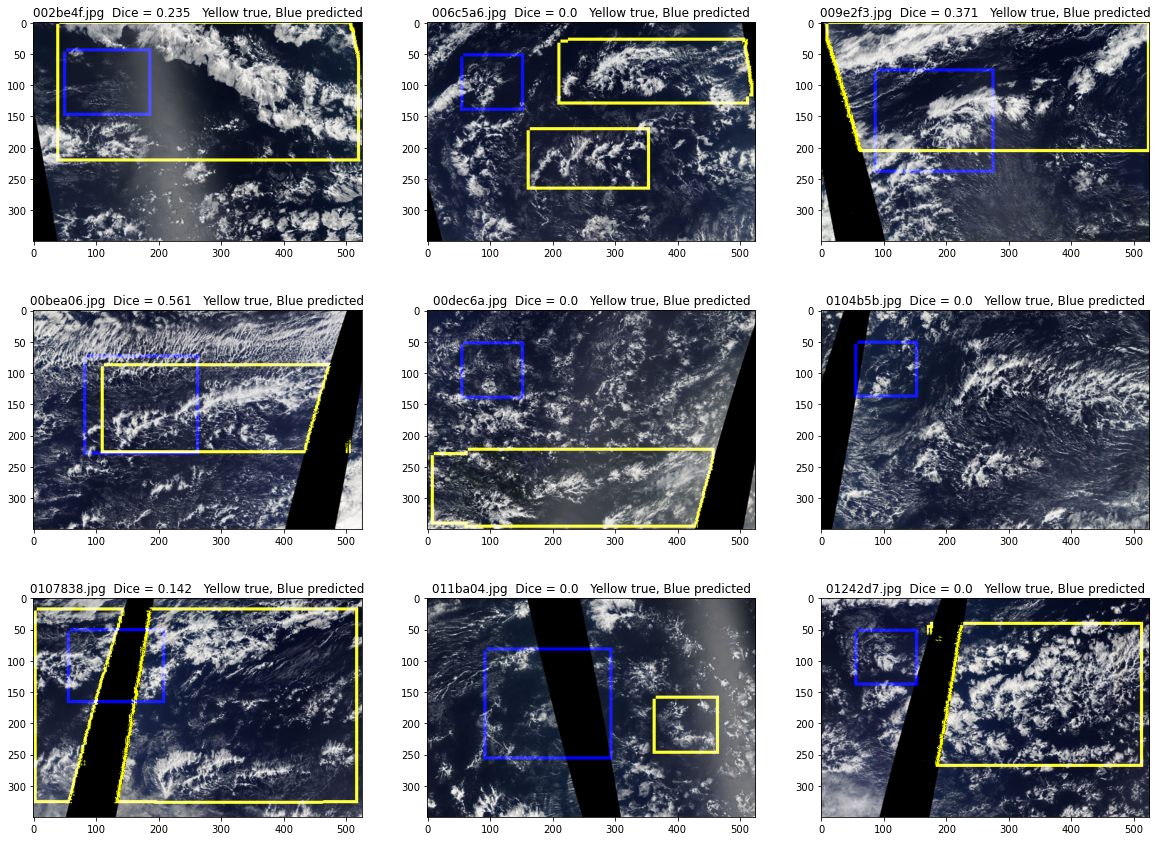

###########################
##### FLOWER CLOUDS #######
###########################


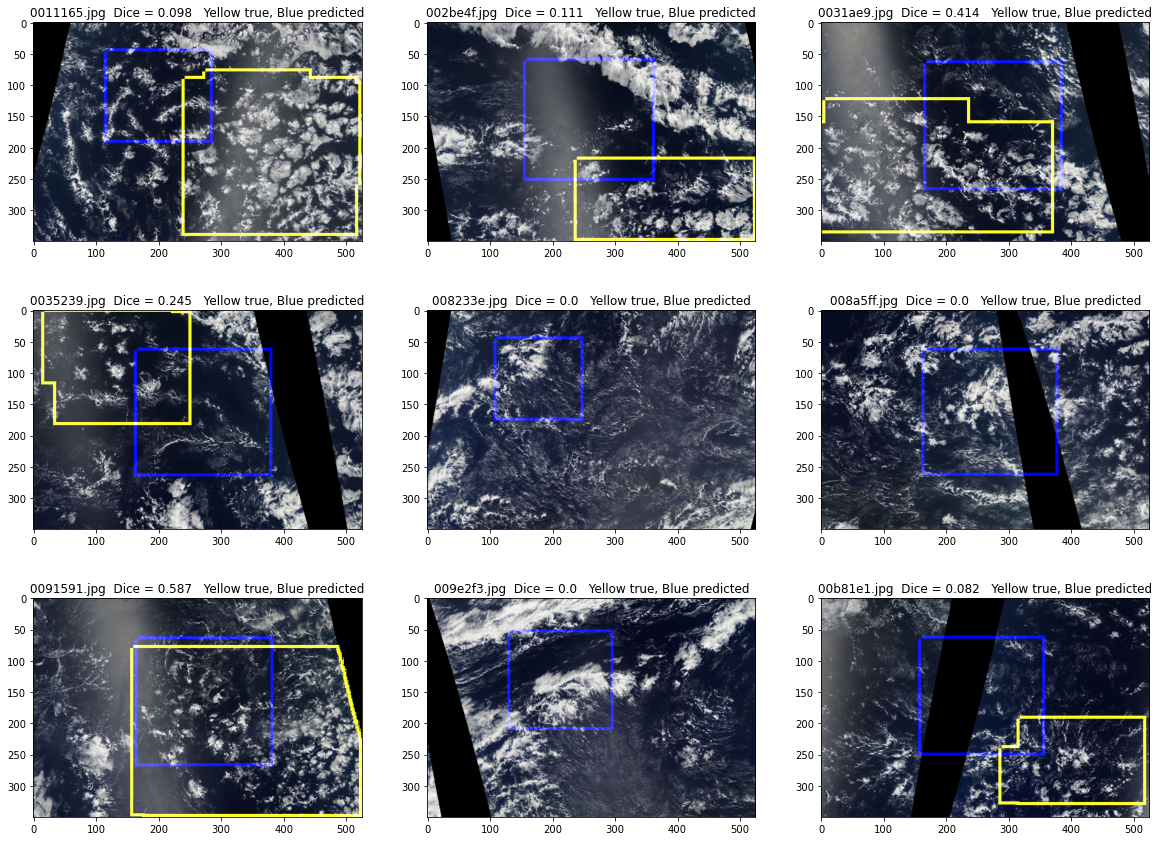

###########################
##### GRAVEL CLOUDS #######
###########################


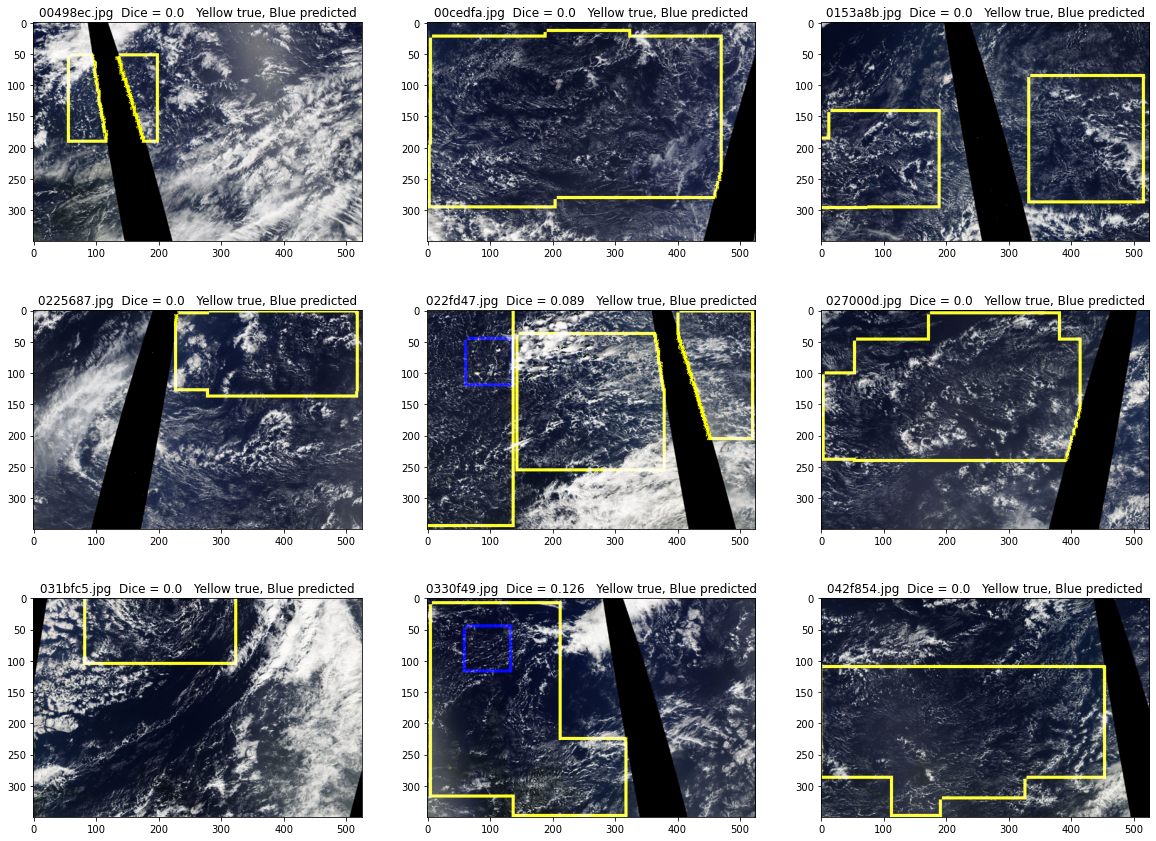

###########################
##### SUGAR CLOUDS #######
###########################


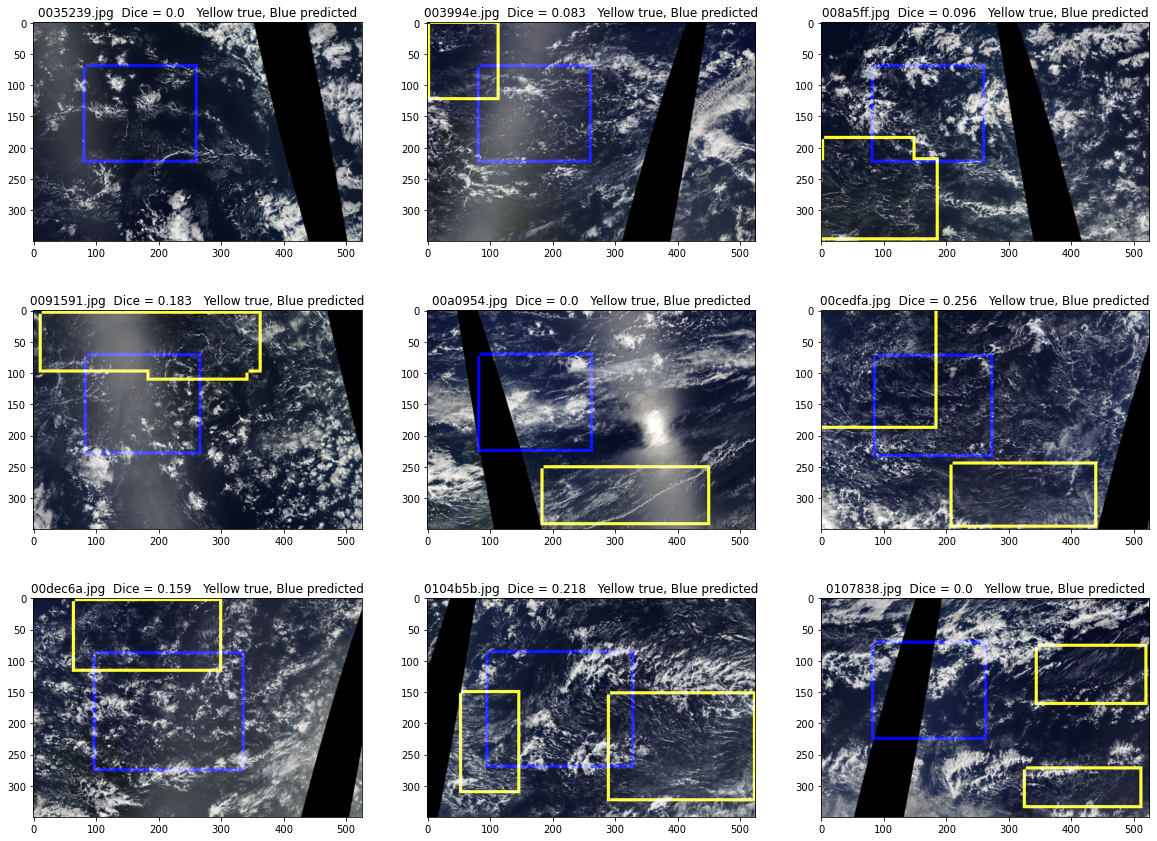

In [41]:
PATH = './data/understanding_clouds/train_images/'
for d in range(1,5):
    print('#'*27); print('#'*5,type2[d-1],'CLOUDS','#'*7); print('#'*27)
    plt.figure(figsize=(20,15)); k=0
    for kk in range(9):
        plt.subplot(3,3,kk+1)
        while (train2.loc[train2.index[k],'o'+str(d)]<0.65): k += 1
        f = train2.index[k]+'.jpg'
        img = Image.open(PATH+f); img = img.resize((525,350)); img = np.array(img)
        rle1 = train2.loc[train2.index[k],'e'+str(d)]; mask = rle2mask(rle1,shrink=4)
        contour = mask2contour(mask,5); img[contour==1,:2] = 255
        rle2 = train2.loc[train2.index[k],'bb'+str(d)]; mask = rle2mask(rle2,shape=(525,350))
        contour = mask2contour(mask,5); img[contour==1,2] = 255
        dice = np.round( dice_coef6(rle1,1,rle2,0),3 )
        plt.title(f+'  Dice = '+str(dice)+'   Yellow true, Blue predicted')
        plt.imshow(img); k += 1
    plt.show()

In [42]:
sub['pr'] = preds.reshape((-1))
sub['EncodedPixels'] = ''
for j in range(4):
    rles = []
    print('Converting bb2rle',j,'..., ',end='')
    for k in range( preds_bb.shape[0] ):
        rle = bb2rle( (preds_bb[k,0,j],preds_bb[k,1,j],preds_bb[k,2,j],preds_bb[k,3,j]) )
        rles.append(rle)
    sub.iloc[j::4,1] = rles
print('Done')
sub.loc[sub.pr<0.65,'EncodedPixels'] = ''
sub[['Image_Label','EncodedPixels']].to_csv('submission.csv',index=False)
sub.head(25)

Converting bb2rle 0 ..., Converting bb2rle 1 ..., Converting bb2rle 2 ..., Converting bb2rle 3 ..., Done


Image_Label                                      EncodedPixels  \
0     002f507.jpg_Fish                                                      
1   002f507.jpg_Flower                                                      
2   002f507.jpg_Gravel  11575 42 11925 42 12275 42 12625 42 12975 42 1...   
3    002f507.jpg_Sugar                                                      
4     0035ae9.jpg_Fish                                                      
5   0035ae9.jpg_Flower                                                      
6   0035ae9.jpg_Gravel                                                      
7    0035ae9.jpg_Sugar  32282 166 32632 166 32982 166 33332 166 33682 ...   
8     0038327.jpg_Fish                                                      
9   0038327.jpg_Flower                                                      
10  0038327.jpg_Gravel                                                      
11   0038327.jpg_Sugar                                                      
12    004f759.jpg_Fish                                                      
13  004f759.jpg_Flower  43801 151 44151 151 44501 151 44851 151 45201 ...   
14  004f759.jpg_Gravel                                                      
15   004f759.jpg_Sugar                                                      
16    005ba08.jpg_Fish                                                      
17  005ba08.jpg_Flower                                                      
18  005ba08.jpg_Gravel  16133 61 16483 61 16833 61 17183 61 17533 61 1...   
19   005ba08.jpg_Sugar                                                      
20    006440a.jpg_Fish                                                      
21  006440a.jpg_Flower                                                      
22  006440a.jpg_Gravel                                                      
23   006440a.jpg_Sugar  32633 170 32983 170 33333 170 33683 170 34033 ...   
24    006f61b.jpg_Fish                                                      

      Image   Label        pr  
0   002f507    Fish  0.108256  
1   002f507  Flower  0.341857  
2   002f507  Gravel  0.745703  
3   002f507   Sugar  0.562083  
4   0035ae9    Fish  0.432283  
5   0035ae9  Flower  0.431888  
6   0035ae9  Gravel  0.505976  
7   0035ae9   Sugar  0.711806  
8   0038327    Fish  0.394967  
9   0038327  Flower  0.390442  
10  0038327  Gravel  0.306913  
11  0038327   Sugar  0.636001  
12  004f759    Fish  0.417029  
13  004f759  Flower  0.810132  
14  004f759  Gravel  0.272202  
15  004f759   Sugar  0.530857  
16  005ba08    Fish  0.291675  
17  005ba08  Flower  0.380376  
18  005ba08  Gravel  0.742754  
19  005ba08   Sugar  0.547856  
20  006440a    Fish  0.544965  
21  006440a  Flower  0.406347  
22  006440a  Gravel  0.410230  
23  006440a   Sugar  0.833420  
24  006f61b    Fish  0.467555